# Waze - Machine Learning Model

This work involves applying tree-based modeling techniques to predict a binary target variable: user churn. The goal is to determine which factors contribute to users leaving the Waze platform.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

In [ ]:
# reading the data
df = pd.read_csv("waze_dataset.csv")
df = df.dropna(subset=["label"])
df.head(10)

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android
5,5,retained,113,103,279.544437,2637,0,0,901.238699,439.101397,15,11,iPhone
6,6,retained,3,2,236.725314,360,185,18,5249.172828,726.577205,28,23,iPhone
7,7,retained,39,35,176.072845,2999,0,0,7892.052468,2466.981741,22,20,iPhone
8,8,retained,57,46,183.532018,424,0,26,2651.709764,1594.342984,25,20,Android
9,9,churned,84,68,244.802115,2997,72,0,6043.460295,2341.838528,7,3,iPhone


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14299 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14299 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14299 non-null  int64  
 3   drives                   14299 non-null  int64  
 4   total_sessions           14299 non-null  float64
 5   n_days_after_onboarding  14299 non-null  int64  
 6   total_navigations_fav1   14299 non-null  int64  
 7   total_navigations_fav2   14299 non-null  int64  
 8   driven_km_drives         14299 non-null  float64
 9   duration_minutes_drives  14299 non-null  float64
 10  activity_days            14299 non-null  int64  
 11  driving_days             14299 non-null  int64  
 12  device                   14299 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


In [ ]:
df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,7503.573117,80.623820,67.255822,189.547409,1751.822505,121.747395,29.638296,4044.401535,1864.199794,15.544653,12.182530
std,4331.207621,80.736502,65.947295,136.189764,1008.663834,147.713428,45.350890,2504.977970,1448.005047,9.016088,7.833835
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000
50%,7504.000000,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000
75%,11257.500000,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


There are a few practical and ethical considerations. A false negative occurs when the model predicts that a user will stay but they actually churn. In this case, Waze could miss out on opportunities to retain those users, such as through targeted notifications or surveys to understand their dissatisfaction. A false positives occurs when the model predicts that a user will leave but they remain loyal. In this scenario, Waze might take unnecessary actions to retain them, potentially causing frustration among these users. While proactive strategies may have unintended negative impacts, a follow-up analysis could determine their effectiveness. If these measures prove reasonable, the advantages of the model would likely outweigh its drawbacks.The risks associated with developing a machine learning model are minimal.

In [ ]:
# dropping column for the ID
df = df.drop("ID", axis=1)

# checking class balance for the label
df["label"].value_counts(normalize=True)

,proportion
label,
retained,0.822645
churned,0.177355


In [ ]:
# creating new column for the distance per driving day
df["km_per_driving_day"] = df["driven_km_drives"] / df["driving_days"]
df.loc[df["km_per_driving_day"]==np.inf, "km_per_driving_day"] = 0

# creating new column for the driven distance per hour
df["km_per_hour"] = df["driven_km_drives"] / (df["duration_minutes_drives"] / 60)

# creating new column for the driven distance per drive
df["km_per_drive"] = df["driven_km_drives"] / df["drives"]
df.loc[df["km_per_drive"]==np.inf, "km_per_drive"] = 0

# creating new column for the driver
df["professional_driver"] = np.where((df["drives"] >= 60) & (df["driving_days"] >= 15), 1, 0)

# creating new column for the percentage of sessions in the last month
df["percent_sessions_in_last_month"] = df["sessions"] / df["total_sessions"]

# creating new column for the number of sessions per day
df["total_sessions_per_day"] = df["total_sessions"] / df["n_days_after_onboarding"]

# creating new column for the percentage of sessions to favorite navigations
df["percent_of_drives_to_favorite"] = (df["total_navigations_fav1"] +
                                       df["total_navigations_fav2"]) / df["total_sessions"]

In [ ]:
# creating new binary column for the label
df["label2"] = np.where(df["label"]=="churned", 1, 0)

# creating new binary column for the device
df["device2"] = np.where(df["device"]=="Android", 0, 1)

Previous analysis has highlighted certain features with strong correlations to churn. New features were engineered for this phase, including `km_per_driving_day` (average kilometers driven per day in the last month), `percent_sessions_in_last_month` (percentage of user sessions occurring in the last month), `professional_driver` (binary feature identifying users with 60+ drives over 15+ days in the past month), `total_sessions_per_day` (average sessions per day since the user joined), `km_per_hour` (average speed in the last month), `km_per_drive` (average kilometers per drive in the last month) and `percent_of_drives_to_favorite` (percentage of sessions navigating to favorite places that is serving as a proxy for trips to familiar destinations). The dataset has a churn rate of approximately 18%, which makes it unbalanced but manageable without class rebalancing. It is crucial to select an evaluation metric that properly accounts for this, as accuracy may not be reliable on an imbalanced dataset.

In [ ]:
def get_best_cv_results(model_name:str, model_object, metric:str):
    """
    This function returns a dataframe with the performance scores for the model
    with the best mean of a given metric across all validation folds.
    """
    # creating dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {"precision": "mean_test_precision",
                   "recall": "mean_test_recall",
                   "f1": "mean_test_f1",
                   "accuracy": "mean_test_accuracy"}

    # getting all the results from the CV
    cv_results = pd.DataFrame(model_object.cv_results_)

    # isolating the row of the dataframe with the max score of the given metric
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # extracting performance scores
    accuracy = best_estimator_results.mean_test_accuracy
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision

    # creating table of results
    table = pd.DataFrame({"model": [model_name],
                          "precision": [precision],
                          "recall": [recall],
                          "F1": [f1],
                          "accuracy": [accuracy]})
    return table


def get_test_results(model_name:str, preds, y_test_data):
    """
    This function generates a table of test scores (precision, recall, f1, accuracy).
    """
    # calculating performance scores
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    # creating table of results
    table = pd.DataFrame({"model": [model_name],
                          "precision": [precision],
                          "recall": [recall],
                          "F1": [f1],
                          "accuracy": [accuracy]})
    return table


def threshold_finder(y_test_data, probabilities, desired_recall):
    """
    This function finds the decision threshold that most closely yields a desired recall score.
    """
    probs = [x[1] for x in probabilities]
    thresholds = np.arange(0, 1, 0.001)
    scores = []
    for threshold in thresholds:
        preds = np.array([1 if x >= threshold else 0 for x in probs])   # new array of predictions
        recall = recall_score(y_test_data, preds)   # calculating recall score for that threshold
        scores.append((threshold, recall))

    distances = []
    for idx, score in enumerate(scores):
        distance = abs(score[1] - desired_recall)   # calculating distance of each score
        distances.append((idx, distance))

    # retrieving the threshold and actual recall score closest to desired recall
    sorted_distances = sorted(distances, key=lambda x: x[1], reverse=False)
    best_idx = sorted_distances[0][0]
    threshold, recall = scores[best_idx]

    return threshold, recall


def plot_confusion_matrix(y_target, y_pred, clf_cv, title):
    """
    This function plots the confusion matrix based on given actual and predicted values.
    """
    # generating array of values for confusion matrix
    log_cm = confusion_matrix(y_target, y_pred, labels=clf_cv.classes_)

    # plotting confusion matrix
    log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=clf_cv.classes_)
    log_disp.plot()
    plt.title(title)
    plt.show()

In [ ]:
# isolating the features (X) and the target variable (y)
y = df["label2"]
X = df.drop(columns=["label", "label2", "device"])

# splitting data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y,
                                              test_size=0.2, random_state=42)

# splitting data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr,
                                                  test_size=0.25, random_state=42)

In [ ]:
# random forest classifier
rf = RandomForestClassifier(random_state=42)

# hyperparameters for tuning
cv_params = {"max_depth": [5, 7, None],
             "max_features": [0.3, 0.6, 0.9, 1.0],
             "max_samples": [0.5, 0.7, 0.9, 1.0],
             "min_samples_leaf": [1, 2, 4, 6],
             "min_samples_split": [2, 4, 6],
             "n_estimators": [75, 100, 200]}

# scoring metrics
scoring_criteria = ["accuracy", "precision", "recall", "f1"]

# GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring_criteria, cv=5, refit="recall")

In [ ]:
rf_cv.fit(X_train, y_train)

In [ ]:
# examining best score
rf_cv.best_score_

0.19955894455191736

In [ ]:
# examining best architecture
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [ ]:
# getting best results based on a specific metric
results = get_best_cv_results("Random Forest Train", rf_cv, "recall")
results

,model,precision,recall,F1,accuracy
0,Random Forest Train,0.482253,0.126132,0.199559,0.820725


In [ ]:
# XGBoost classifier
xgb_clf = XGBClassifier(objective="binary:logistic", random_state=0)

# hyperparameters for tuning
cv_params = {"learning_rate": [0.1, 0.01, 0.001],
             "max_depth": [6, 8, 10, 12],
             "min_child_weight": [1, 3, 5],
             "n_estimators": [300, 400, 500]}

# scoring metrics
scoring_criteria = ["accuracy", "precision", "recall", "f1"]

# GridSearchCV object
xgb_cv = GridSearchCV(xgb_clf, cv_params, scoring=scoring_criteria, cv=5, refit="recall")

In [ ]:
xgb_cv.fit(X_train, y_train)

In [ ]:
# examining best score
xgb_cv.best_score_

0.16294866264020708

In [ ]:
# examining best architecture
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 3,
 'n_estimators': 300}

In [ ]:
# getting best results based on a specific metric
xgb_cv_results = get_best_cv_results("XGBoost Train", xgb_cv, "recall")
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest Train,0.482253,0.126132,0.199559,0.820725
0,XGBoost Train,0.420262,0.162949,0.234394,0.811633


In [ ]:
# getting scores on validation data for the random forest model
rf_val_preds = rf_cv.best_estimator_.predict(X_val)
rf_val_scores = get_test_results("Random Forest Val", rf_val_preds, y_val)
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest Train,0.482253,0.126132,0.199559,0.820725
0,XGBoost Train,0.420262,0.162949,0.234394,0.811633
0,Random Forest Val,0.433566,0.122288,0.190769,0.816084


In [ ]:
# getting scores on validation data for the random forest model
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)
xgb_val_scores = get_test_results("XGBoost Val", xgb_val_preds, y_val)
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest Train,0.482253,0.126132,0.199559,0.820725
0,XGBoost Train,0.420262,0.162949,0.234394,0.811633
0,Random Forest Val,0.433566,0.122288,0.190769,0.816084
0,XGBoost Val,0.409756,0.165680,0.235955,0.809790


In [ ]:
# getting scores on testing data for the best model
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)
xgb_test_scores = get_test_results("XGBoost Test", xgb_test_preds, y_test)
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest Train,0.482253,0.126132,0.199559,0.820725
0,XGBoost Train,0.420262,0.162949,0.234394,0.811633
0,Random Forest Val,0.433566,0.122288,0.190769,0.816084
0,XGBoost Val,0.409756,0.165680,0.235955,0.809790
0,XGBoost Test,0.405286,0.181460,0.250681,0.807692


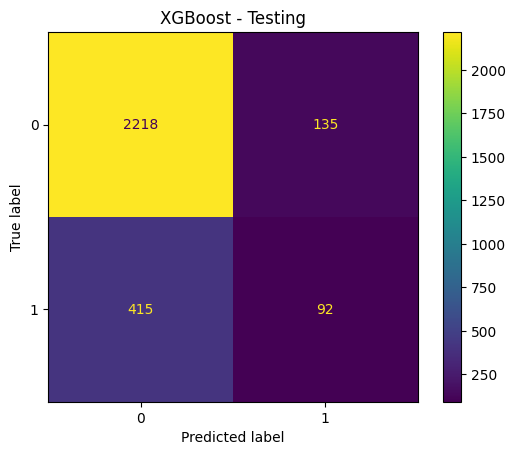

In [ ]:
# plotting confusion matrix for the best model
plot_confusion_matrix(y_test, xgb_test_preds, xgb_cv, "XGBoost - Testing")

Given the minimal risk of false positives, the recall score was prioritized for model evaluation. The best-performing random forest and XGBoost models were tested on validation data, with the better one chosen as the final model. The performance metrics remained relatively consistent during all phases, with the results being within acceptable performance ranges. The model identified 16.6% of users who actually churned, with three times as many false negatives as false positives. The XGBoost model utilized a broader range of features compared to the logistic regression model, which had previously relied heavily on a single feature (i.e. the number of activity days). This highlights the importance of feature engineering, as it significantly boosted the model's performance. Models can differ in the features they prioritize, so it is important to thoroughly evaluate feature interactions and their relevance to the target variable. Not all data will yield predictive power, and it is important to recognize when a model has reached its limits. The suitability of the model depends on its intended use. For high-stakes business decisions, the model's limited predictive power might not be sufficient. However, it can be valuable for guiding further exploratory analysis. Finally, it should be noted that a three-way data split reduces the training data size but allows for more accurate model performance evaluation by using a separate validation set before testing.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

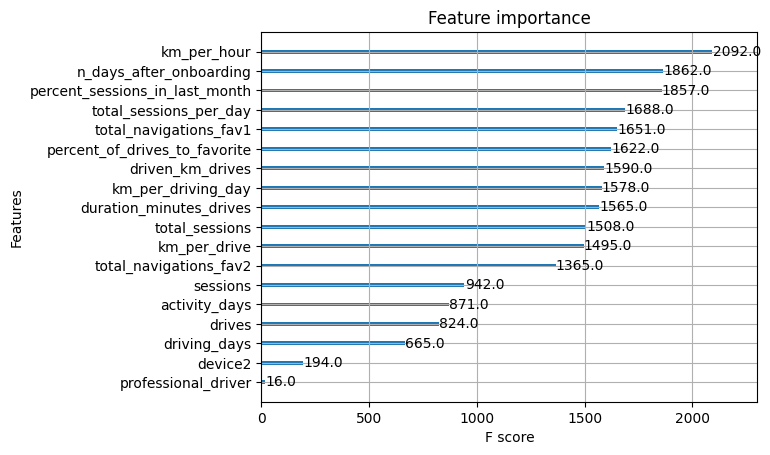

In [ ]:
# plotting importance
plot_importance(xgb_cv.best_estimator_)

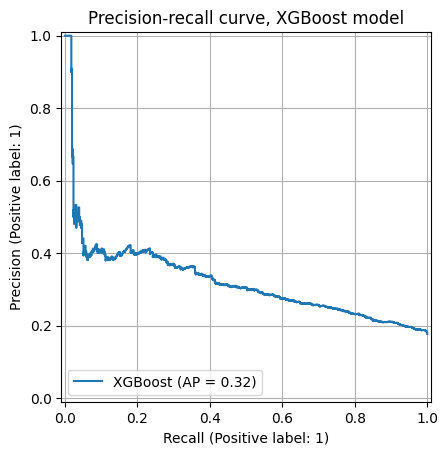

In [ ]:
# plotting precision-recall curve
display = PrecisionRecallDisplay.from_estimator(xgb_cv.best_estimator_,
                                                X_test,
                                                y_test,
                                                zorder=3,
                                                name="XGBoost")
plt.title("Precision-recall curve, XGBoost model")
plt.grid(zorder=0)
plt.show()

In [ ]:
# getting predicted probabilities on the testing data
predicted_probabilities = xgb_cv.best_estimator_.predict_proba(X_test)

# creating list of target probabilities
probs = [x[1] for x in predicted_probabilities]

# creating array of new predictions that assigns a 1 to any value greater than 0.4
new_preds = np.array([1 if x >= 0.4 else 0 for x in probs])

# getting scores on testing data
get_test_results("XGBoost (thr = 0.4)", new_preds, y_test)

,model,precision,recall,F1,accuracy
0,XGBoost (thr = 0.4),0.398058,0.242604,0.301471,0.800699


In [ ]:
# getting the predicted probabilities from the best model
probabilities = xgb_cv.best_estimator_.predict_proba(X_test)

# calculating best threshold
prob_threshold, recall_score_val = threshold_finder(y_test, probabilities, 0.45)
print("Optimal Threshold:", prob_threshold)
print("Recall:", recall_score_val)

Optimal Threshold: 0.14400000000000002
Recall: 0.44970414201183434


In [ ]:
# creating array of new predictions that assigns a 1 to any value greater than the optimal threshold
probs = [x[1] for x in probabilities]
new_preds = np.array([1 if x >= prob_threshold else 0 for x in probs])

# getting scores on testing data for the best model
get_test_results("XGBoost (thr = " + str(round(prob_threshold, 3)) + ")", new_preds, y_test)

,model,precision,recall,F1,accuracy
0,XGBoost (thr = 0.144),0.312329,0.449704,0.368634,0.726923


To conclude, the logistic regression model offers interpretability by highlighting the influence of each feature on predictions. The tree-based ensembles often provide better predictive performance and are more versatile, with less need for data preprocessing. To enhance predictions, further feature engineering could be beneficial, especially with domain-specific insights. Exploring different combinations of predictors might also help to reduce noise and improve accuracy. More detailed data on user interactions and drive-level metrics, such as drive times and location data, would also likely improve the model's performance.
